# Team Members

- **Student ID:** 0001111416  
  **Full Name:** Alessio Pittiglio  
  **Institutional Email:** alessio.pittiglio@studio.unibo.it

- **Student ID:** 0001086355  
  **Full Name:** Parsa Mastouri Kashani  
  **Institutional Email:** parsa.mastouri@studio.unibo.it

# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
# !unzip dataset.zip

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

---

# Our solution

The computer vision system we designed is based on a variant of the **Generalized Hough Transform (GHT)** that uses local invariant features such as SIFT. This approach is also often referred to as the Star Model. The system operates in two phases: an offline phase and an online phase.

### Offline phase

The goal of the offline phase is to build a model of the object to be detected starting from a template image.

1. First, we extract the local invariant features from the template image.
2. The object model is defined as a collection of these features. For each feature, we store its position $(x,y)$, its canonical orientation $\theta$, its characteristic scale $s$, and its SIFT descriptor vector.
3. A reference point is chosen for the object, typically the barycenter (centroid) of all keypoints.
4. For each keypoint, a joining vector $\mathbf{r}$ is computed. This vector points from the keypoint's position to the reference point and is stored as an additional attribute for each keypoint.

At the end of this phase, we obtain the **Star Model**. The name comes from the fact that visually, these vectors all point toward the center, giving the appearance of a star.

<figure style="text-align: center;">
  <img src="https://i.ibb.co/Y4pSwQzP/joining-vectors.png" alt="joining-vectors">
  <figcaption><em>Figure 1: Example of joining vectors drawn on some keypoints of the model.</em></figcaption>
</figure>

### Online phase

The actual detection takes place during the online phase. The Star Model is used to find instances of the object in new images.

1. The same type of local features are extracted from the target image.
2. The descriptors of the target image's keypoints are matched against the descriptors of the keypoints stored in the Star Model. Lowe's ratio test is typically used to keep only the reliable matches and discard ambiguous ones.
3. Voting represents the core of this method, where its strength truly lies. For each match, a vote is cast for the most probable position of the reference point in the target image. Each match also provides hypotheses for rotation and scale.
    - For rotation, the difference between the canonical orientations of the target and model keypoints gives an estimate of the object's rotation.
    - For scale, the ratio of the characteristic scales of the target and model keypoints gives an estimate of the object's scale change.
    
    Once these estimates are obtained, we transform the joining vector from the model keypoint and add it to the target keypoint's position to cast a vote for the reference point.

4. Votes are cast into a 2D accumulator. After all matches have voted, peaks in the accumulator array indicate the likely presence and position of the object.

<figure style="text-align: center;">
  <img src="https://i.ibb.co/9k5yGnLz/accumulator-heatmap.png" alt="accumulator-heatmap" width="400">
  <figcaption><em>Figure 2: Accumulator grid heatmap showing votes distribution.</em></figcaption>
</figure>

## Bounding box estimation phase

To this already robust system, we added a third phase to estimate a bounding box for the object. Once the peak is found (using a local maximum detection algorithm on the grid), we introduce a data structure to keep track of which matches voted for that reference point. These matches are then used to estimate a transformation via least squares (LLS).

We opted for a similarity transformation instead of a homography for two main reasons:
1. It requires fewer points to estimate (3 instead of the 4 required for homography)
2. It is quite reliable in our case since the objects we aim to detect are mostly rectangular.

## Inverse matching

The standard SIFT algorithm, which uses Lowe's ratio test, is designed to find one-to-one correspondences between keypoints in the template and those in the target image. By its nature, it is poorly suited for scenarios where multiple instances need to be detected, especially when a model feature appears multiple times in the target image.

For example, if a model keypoint has three matches in the scene, Lowe's ratio will keep at most one of them. In our early experiments, sequentially masking detected objects with a black box and re-running SIFT detection produced good results, but was extremely inefficient. To overcome this limitation, we changed the matching strategy. Instead of asking:

> "Which scene feature best matches the model feature?"

we ask:

> "For each scene feature, which model feature does it resemble the most?"

## Additional improvements

### CLAHE
Another improvement was the use of CLAHE for image pre-processing. This locally enhances the contrast of an image while limiting noise amplification through a "clip limit". This resulted in an increased number of detected keypoints and, consequently, more votes in the accumulator.

CLAHE can be applied in two different ways with completely different results:
- Apply it directly to the grayscale image.
- Convert the image to the LAB color space, apply it only to the L channel, and then continue the pipeline using that L channel.

In our case, empirical evaluation showed that the second approach produced better results.

<figure style="text-align: center;">
  <img src="https://i.ibb.co/PGYSgwDM/clahe-effect-png.png" alt="clahe-effect">
  <figcaption><em>Figure 3: Visual comparison of CLAHE effect.</em></figcaption>
</figure>

### Adaptive detection strategy

To improve the robustness of the detection, an adaptive approach based on the Laplacian variance of the image is used. This metric is an indicator of the image sharpness. In scenes with high sharpness, applying CLAHE combined with a high number of SIFT octave layers can degrade the quality of the matching. If the Laplacian variance is above a threshold, the system automatically switches to a more conservative configuration by disabling CLAHE.

### Structural Similarity (SSIM) verification

To reduce false positives, we implemented a final verification step using the Structural Similarity Index (SSIM). The main detection pipeline, while robust, relies on the geometric arrangement of keypoints. This can occasionally lead to incorrect detections. To mitigate this, after a potential instance is located, its bounding box is used to warp the corresponding scene patch back to the model's reference frame. We then compute the SSIM score between the warped patch and the original model image. Detections falling below a certain threshold are discarded.

## 1. Imports and setup

In [2]:
!pip install scikit-image

In [3]:
import math
import os
import re
import logging
from dataclasses import dataclass

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.metrics import structural_similarity as ssim

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

## 2. Utility functions

In [4]:
def calculate_iou(box_a, box_b):
    """Compute IoU between two quadrilateral bounding boxes.
    
    For the intersection area calculation, it simplifies the problem by using
    the axis-aligned bounding boxes of the quadrilaterals

    Args:
        box_a (np.ndarray): An array of shape (4, 2) representing the four
            corners of the first bounding box.
        box_b (np.ndarray): An array of shape (4, 2) representing the four
            corners of the second bounding box.

    Returns:
        float: The IoU score, a value between 0.0 and 1.0.
    """
    x_a_min, y_a_min = np.min(box_a, axis=0).ravel()
    x_a_max, y_a_max = np.max(box_a, axis=0).ravel()
    x_b_min, y_b_min = np.min(box_b, axis=0).ravel()
    x_b_max, y_b_max = np.max(box_b, axis=0).ravel()

    inter_x_min = max(x_a_min, x_b_min)
    inter_y_min = max(y_a_min, y_b_min)
    inter_x_max = min(x_a_max, x_b_max)
    inter_y_max = min(y_a_max, y_b_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    area_a = cv2.contourArea(box_a)
    area_b = cv2.contourArea(box_b)

    union_area = area_a + area_b - inter_area
    iou = inter_area / union_area if union_area > 0 else 0

    return iou


def non_max_suppression(detections, iou_threshold=0.3):
    """Performs Non-Maximum Suppression (NMS) on a list of detections.

    Args:
        detections (list[dict]): A list of detection dictionaries. Each dictionary
            must contain at least 'votes' (the confidence score) and
            'bounding_box' (a NumPy array of shape (4, 2)).
        iou_threshold (float, optional): The IoU threshold above which a box
            is considered overlapping and will be suppressed. Defaults to 0.3.

    Returns:
        list[dict]: The filtered list of detections after applying NMS.
    """
    if not detections:
        return []

    detections = sorted(detections, key=lambda d: d["votes"], reverse=True)
    kept = []

    while detections:
        best = detections.pop(0)
        kept.append(best)

        remaining_detections = []
        for det in detections:
            iou = calculate_iou(best["bounding_box"], det["bounding_box"])
            if iou < iou_threshold:
                remaining_detections.append(det)

        detections = remaining_detections

    return kept


def format_and_print_results(all_results, scene_filename):
    """Formats and prints the detection results for a given scene
    
    Follows the output format specified in the assignment requirements.

    Args:
        all_results (dict): A dictionary mapping book names (str) to a list of
            their detected instances (list[dict]). Each instance dictionary
            contains details like 'corners_dict' and 'area'.
        scene_filename (str): The filename of the scene image to be included
            in the output header.
    """
    print(f"Results for scene: {scene_filename}")
    print("------------------------------------")
    if not all_results:
        print("No books found.")
        return

    for book_name, instances in all_results.items():
        print(f"{book_name} - {len(instances)} instance(s) found:")
        for i, inst in enumerate(instances, 1):
            corners = inst["corners_dict"]
            area = inst["area"]
            formatted_corners = {k: tuple(map(int, v)) for k, v in corners.items()}

            print(
                f"  Instance {i} {{"
                f"top_left: {formatted_corners['top_left']}, "
                f"top_right: {formatted_corners['top_right']}, "
                f"bottom_right: {formatted_corners['bottom_right']}, "
                f"bottom_left: {formatted_corners['bottom_left']}, "
                f"area: {area:.0f}px}}"
            )

    print("\n" + "=" * 50)


def natural_sort_key(s):
    return [
        int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", s)
    ]

## 3. Star Model and Accumulator

In [5]:
class Feature:
    """Represents a single local feature (e.g., SIFT)."""
    def __init__(self, keypoint, descriptor):
        self.position = np.array(keypoint.pt)
        self.angle = keypoint.angle
        self.size = keypoint.size
        self.descriptor = descriptor
        self.joining_vector = None


class StarModel:
    """Represents the Star Model for Generalized Hough Transform (GHT)."""
    def __init__(self):
        self.features = []
        self.barycenter = None

    def add_feature(self, feature):
        self.features.append(feature)

    def compute_barycenter(self):
        if not self.features:
            return None
        points = np.array([f.position for f in self.features])
        self.barycenter = np.mean(points, axis=0)
        return self.barycenter

    def compute_joining_vectors(self):
        if self.barycenter is None:
            return None
        for feature in self.features:
            feature.joining_vector = self.barycenter - feature.position


class Accumulator:
    """A 2D accumulator grid for casting and analyzing votes in the GHT."""
    def __init__(self, image_shape, bin_size=2):
        self.image_height, self.image_width = image_shape
        self.bin_size = bin_size

        grid_height = math.ceil(self.image_height / self.bin_size)
        grid_width = math.ceil(self.image_width / self.bin_size)

        self.grid = np.zeros((grid_height, grid_width), dtype=np.int32)
        self.votes_per_bin = [
            [[] for _ in range(grid_width)] for _ in range(grid_height)
        ]

    def _quantize(self, point):
        x, y = point
        bin_x = int(x / self.bin_size)
        bin_y = int(y / self.bin_size)
        return bin_y, bin_x

    def vote(self, point, match):
        """Casts a single vote for a reference point location.

        Args:
            point (tuple[float, float]): The (x, y) coordinates of the predicted
                reference point.
            match (cv2.DMatch): The match object that generated this vote.
        """
        x, y = point
        if not (0 <= x < self.image_width and 0 <= y < self.image_height):
            return
        bin_y, bin_x = self._quantize(point)
        self.grid[bin_y, bin_x] += 1
        self.votes_per_bin[bin_y][bin_x].append(match)

    def find_peaks(self, min_votes, nms_window_size):
        """Finds local maxima (peaks) in the accumulator grid.

        Args:
            min_votes (int): The minimum number of votes for a peak to be considered.
            nms_window_size (int): The size of the window for non-maximum suppression
                on the accumulator grid.

        Returns:
            list[dict]: A list of peaks, sorted by vote count. Each peak is a
                dictionary containing its position, vote count, and the list of
                contributing matches.
        """
        if self.grid.max() < min_votes:
            return []

        thresholded_grid = self.grid.copy()
        thresholded_grid[thresholded_grid < min_votes] = 0

        local_max = maximum_filter(thresholded_grid, size=nms_window_size)
        peaks_mask = (thresholded_grid == local_max) & (thresholded_grid > 0)
        peak_indices = np.argwhere(peaks_mask)

        peaks = []
        for bin_y, bin_x in peak_indices:
            center_x = (bin_x + 0.5) * self.bin_size
            center_y = (bin_y + 0.5) * self.bin_size

            peaks.append(
                {
                    "position": (center_x, center_y),
                    "votes": self.grid[bin_y, bin_x],
                    "contributing_matches": self.votes_per_bin[bin_y][bin_x],
                }
            )

        peaks.sort(key=lambda p: p["votes"], reverse=True)
        return peaks

    def calculate_local_density(self, window_size=21):
        """Calculates a spatial dispersion score for the votes.

        A high score indicates that votes are tightly clustered around the main peak,
        suggesting a confident detection. A low score suggests votes are widely
        dispersed, indicating a likely false positive.

        Args:
            window_size (int): The size of the window around the main peak to
                calculate the energy from.

        Returns:
            float: The local density score.
        """
        if window_size % 2 == 0:
            raise ValueError("window_size must be an odd number.")

        peak_value = np.max(self.grid)
        if peak_value == 0:
            return 0.0

        peak_coords = np.unravel_index(np.argmax(self.grid), self.grid.shape)
        half_win = window_size // 2

        r_start = max(0, peak_coords[0] - half_win)
        r_end = min(self.grid.shape[0], peak_coords[0] + half_win + 1)
        c_start = max(0, peak_coords[1] - half_win)
        c_end = min(self.grid.shape[1], peak_coords[1] + half_win + 1)

        local_window = self.grid[r_start:r_end, c_start:c_end]

        local_energy = np.sum(local_window)

        window_area = local_window.size
        if window_area == 0:
            return 0.0

        local_density_score = local_energy / window_area

        return local_density_score

## 4. SIFT + GHT Detector

In [6]:
@dataclass
class DetectorConfig:
    bin_size: int = 6
    num_octave_layers: int = 3
    ratio_threshold: float = 0.7
    min_votes: int = 2
    nms_window_size: int = 5
    nms_iou_threshold: float = 0.3
    min_match_count: int = 4
    min_area: int = 1000
    dispersion_threshold: float = 0.1
    use_clahe: bool = False
    use_structural_similarity_filter: bool = False
    ssim_threshold: float = 0.3
    adaptive_strategy: bool = True
    min_votes_ratio: float = 0.1
    laplacian_var_threshold: int = 2200
    verbose: bool = False

In [7]:
class SiftGhtDetector:
    def __init__(self, config: DetectorConfig):
        self.config = config
        self.sift_default = cv2.SIFT_create(nOctaveLayers=config.num_octave_layers)
        self.sift_alternative = cv2.SIFT_create()

        self.clahe = (
            cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            if config.use_clahe
            else None
        )

    def _preprocess_image(self, image):
        if self.clahe is None:
            return image
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        cl = self.clahe.apply(l)
        return cl

    def detect_and_compute(self, image, use_alternative_strategy=False):
        if use_alternative_strategy:
            if self.config.verbose:
                logger.info("Using ALTERNATIVE strategy (3 octaves, no CLAHE).")
            sift_detector = self.sift_alternative
            processed = image
        else:
            if self.config.verbose:
                logger.info("Using DEFAULT strategy (5 octaves, with CLAHE).")
            processed = self._preprocess_image(image)
            sift_detector = self.sift_default

        keypoints, descriptors = sift_detector.detectAndCompute(processed, None)
        features = [Feature(kp, desc) for kp, desc in zip(keypoints, descriptors)]
        if self.config.verbose:
            logger.info(f"Detected {len(features)} features.")
        return features

    def build_model(self, model_image, use_alternative_strategy=False):
        features = self.detect_and_compute(model_image, use_alternative_strategy)
        model = StarModel()
        for feature in features:
            model.add_feature(feature)
        model.compute_barycenter()
        model.compute_joining_vectors()
        if self.config.verbose:
            logger.info(
                f"Model built with {len(model.features)} features. "
                f"Barycenter: {model.barycenter}."
            )
        return model

    def match_features(self, model, target_features):
        model_descriptors = np.array([f.descriptor for f in model.features])
        target_descriptors = np.array([f.descriptor for f in target_features])

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        knn_matches = flann.knnMatch(target_descriptors, model_descriptors, k=2)
        good_matches = []

        for match_pair in knn_matches:
            if len(match_pair) < 2:
                continue

            m, n = match_pair
            if m.distance < self.config.ratio_threshold * n.distance:
                good_match = cv2.DMatch(
                    _queryIdx=m.trainIdx, _trainIdx=m.queryIdx, _distance=m.distance
                )
                good_matches.append(good_match)

        if self.config.verbose:
            logger.info(f"Found {len(good_matches)} good matches.")
        return good_matches

    def apply_scale_rotation(self, joining_vector, scale, rotation):
        scaled_vector = scale * joining_vector
        angle_rad = np.deg2rad(rotation)
        rotation_matrix = np.array(
            [
                [np.cos(angle_rad), -np.sin(angle_rad)],
                [np.sin(angle_rad), np.cos(angle_rad)],
            ]
        )
        rotated_vector = np.dot(rotation_matrix, scaled_vector)
        return rotated_vector

    def vote_for_reference_points(
        self, model, target_features, good_matches, target_image_shape
    ):
        accumulator = Accumulator(target_image_shape[:2], bin_size=self.config.bin_size)
        for match in good_matches:
            model_idx = match.queryIdx
            target_idx = match.trainIdx

            model_feature = model.features[model_idx]
            target_feature = target_features[target_idx]

            scale_ratio = target_feature.size / model_feature.size
            rotation_diff = target_feature.angle - model_feature.angle

            transformed_vector = self.apply_scale_rotation(
                model_feature.joining_vector, scale_ratio, rotation_diff
            )
            predicted_reference = target_feature.position + transformed_vector
            accumulator.vote(predicted_reference, match)

        return accumulator

    def estimate_affine_transform(self, model_image, matches, model, target_features):
        if len(matches) < 3:
            if self.config.verbose:
                logger.info("Not enough matches to compute transformation.")
            return None

        src_pts = np.float32(
            [model.features[m.queryIdx].position for m in matches]
        ).reshape(-1, 1, 2)
        dst_pts = np.float32(
            [target_features[m.trainIdx].position for m in matches]
        ).reshape(-1, 1, 2)

        M_affine, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)
        if M_affine is None:
            return None

        h, w = model_image.shape[:2]
        corners = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]]).reshape(
            -1, 1, 2
        )
        dst = cv2.transform(corners, M_affine)
        return np.int32(dst)

    def filter_by_structural_similarity(self, detections, model_image, target_image):
        if not detections:
            return []

        model_gray = cv2.cvtColor(model_image, cv2.COLOR_BGR2GRAY)
        h, w = model_gray.shape

        kept_detections = []
        for det in detections:
            bbox = det["bounding_box"]

            dst_pts = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]])
            src_pts = np.float32(bbox).reshape(4, 2)

            transform_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)

            warped_patch = cv2.warpPerspective(target_image, transform_matrix, (w, h))
            warped_patch_gray = cv2.cvtColor(warped_patch, cv2.COLOR_BGR2GRAY)

            score = ssim(
                model_gray,
                warped_patch_gray,
                data_range=warped_patch_gray.max() - warped_patch_gray.min(),
            )

            if score >= self.config.ssim_threshold:
                if self.config.verbose:
                    logger.info(
                        f"Detection at {det['position']} PASSED structural check "
                        f"(SSIM: {score:.3f})."
                    )
                kept_detections.append(det)
            else:
                if self.config.verbose:
                    logger.warning(
                        f"Detection at {det['position']} REJECTED by structural check "
                        f"(SSIM: {score:.3f} < {self.ssim_threshold})."
                    )

        return kept_detections

    def detect(self, model_image, target_image):
        """Detects all instances of a model object in a target image.

        This is the main method that executes the full detection pipeline.

        Args:
            model_image (np.ndarray): The BGR image of the object to detect.
            target_image (np.ndarray): The BGR scene image to search within.

        Returns:
            tuple: (peaks, accumulator, filtered_bounding_boxes)
                - peaks (list[dict]): Raw peaks found in the accumulator.
                - accumulator (Accumulator): The accumulator object with all votes.
                - filtered (list[dict]): The final list of filtered and verified
                  detection dictionaries, each with a 'bounding_box'.
        """
        use_alternative = False
        if self.config.adaptive_strategy:
            target_gray = cv2.cvtColor(target_image, cv2.COLOR_BGR2GRAY)
            laplacian_var = cv2.Laplacian(target_gray, cv2.CV_64F).var()

            if laplacian_var > self.config.laplacian_var_threshold:
                if self.config.verbose:
                    logger.warning(
                        "High Laplacian variance detected (%.2f > %.2f). "
                        "Switching to robust strategy.",
                        laplacian_var,
                        self.config.laplacian_var_threshold,
                    )
                use_alternative = True

        model = self.build_model(model_image, use_alternative_strategy=use_alternative)
        target_features = self.detect_and_compute(
            target_image, use_alternative_strategy=use_alternative
        )
        good_matches = self.match_features(model, target_features)

        accumulator = self.vote_for_reference_points(
            model, target_features, good_matches, target_image.shape
        )

        peaks = accumulator.find_peaks(
            min_votes=self.config.min_votes, nms_window_size=self.config.nms_window_size
        )

        score = accumulator.calculate_local_density()
        if score < self.config.dispersion_threshold:
            if self.config.verbose:
                logger.warning(
                    "Spatial dispersion score %.4f below threshold %.4f, "
                    "rejecting detection.",
                    score,
                    self.config.dispersion_threshold,
                )
            return [], accumulator, []

        if self.config.verbose:
            logger.info(f"Found {len(peaks)} peaks in accumulator.")

        max_votes = max(p["votes"] for p in peaks)
        dynamic_min_votes = int(max_votes * self.config.min_votes_ratio)
        final_min_votes_threshold = max(self.config.min_votes, dynamic_min_votes)
        peaks = [p for p in peaks if p["votes"] >= final_min_votes_threshold]

        bounding_boxes = []
        for peak in peaks:
            matches = peak["contributing_matches"]
            bbox = self.estimate_affine_transform(
                model_image, matches, model, target_features
            )
            if bbox is not None:
                bounding_boxes.append(
                    {
                        "position": peak["position"],
                        "votes": peak["votes"],
                        "bounding_box": bbox,
                        "corners_dict": {
                            "top_left": tuple(bbox[0][0]),
                            "top_right": tuple(bbox[1][0]),
                            "bottom_right": tuple(bbox[2][0]),
                            "bottom_left": tuple(bbox[3][0]),
                        },
                        "area": cv2.contourArea(bbox),
                    }
                )

        filtered = non_max_suppression(bounding_boxes, self.config.nms_iou_threshold)

        if self.config.verbose:
            logger.info(
                f"Detected {len(bounding_boxes)} raw instances, kept {len(filtered)} after NMS.",
            )
        if self.config.use_structural_similarity_filter:
            filtered = self.filter_by_structural_similarity(
                filtered, model_image, target_image
            )

        return peaks, accumulator, filtered

## 5. Experiment setup

In [8]:
MODELS_DIR = os.path.join("dataset", "models")
SCENES_DIR = os.path.join("dataset", "scenes")

In [9]:
models = {}
config = DetectorConfig(
    bin_size=6,
    num_octave_layers=5,
    ratio_threshold=0.75,
    min_votes=3,
    nms_window_size=5,
    nms_iou_threshold=0.4,
    use_clahe=True,
    dispersion_threshold=0.1,
    verbose=False,
    adaptive_strategy=True,
    laplacian_var_threshold=2200,
    use_structural_similarity_filter=True,
    ssim_threshold=0.18,
    min_votes_ratio=0.2,
)

detector = SiftGhtDetector(config)

In [10]:
model_files = sorted(
    [
        f
        for f in os.listdir(MODELS_DIR)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ],
    key=natural_sort_key,
)

In [11]:
for i, filename in enumerate(model_files):
    book_name = f"Book {i}"
    model_path = os.path.join(MODELS_DIR, filename)
    models[book_name] = cv2.imread(model_path)

## 6. Running the detection and visualizing results

In [ ]:
scenes = 

Results for scene: scene_0.jpg
------------------------------------
No books found.


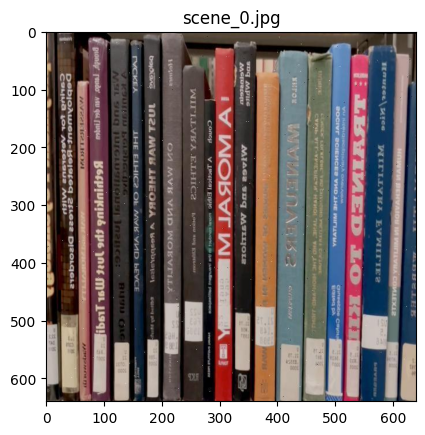

Results for scene: scene_1.jpg
------------------------------------
Book 18 - 2 instance(s) found:
  Instance 1 {top_left: (441, 42), top_right: (490, 42), bottom_right: (490, 520), bottom_left: (441, 520), area: 23422px}
  Instance 2 {top_left: (488, 38), top_right: (537, 39), bottom_right: (530, 513), bottom_left: (481, 512), area: 23233px}



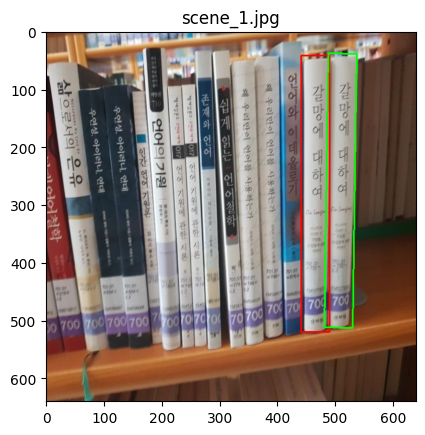

Results for scene: scene_2.jpg
------------------------------------
Book 17 - 1 instance(s) found:
  Instance 1 {top_left: (283, 25), top_right: (318, 25), bottom_right: (318, 503), bottom_left: (283, 503), area: 16730px}



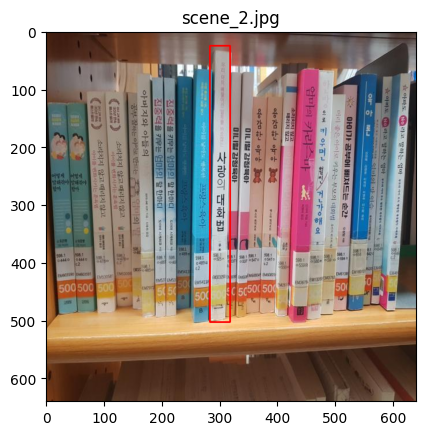

Results for scene: scene_3.jpg
------------------------------------
Book 16 - 2 instance(s) found:
  Instance 1 {top_left: (377, 209), top_right: (425, 209), bottom_right: (425, 542), bottom_left: (377, 542), area: 15984px}
  Instance 2 {top_left: (424, 209), top_right: (473, 210), bottom_right: (468, 550), bottom_left: (418, 549), area: 16836px}



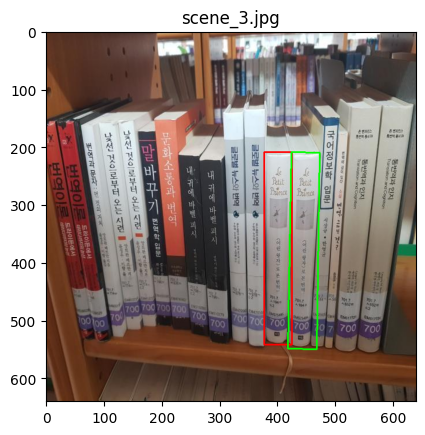

Results for scene: scene_4.jpg
------------------------------------
Book 14 - 2 instance(s) found:
  Instance 1 {top_left: (92, 1), top_right: (135, 1), bottom_right: (135, 617), bottom_left: (92, 617), area: 26488px}
  Instance 2 {top_left: (54, -2), top_right: (98, -2), bottom_right: (103, 619), bottom_left: (59, 619), area: 27324px}
Book 15 - 2 instance(s) found:
  Instance 1 {top_left: (226, 48), top_right: (267, 48), bottom_right: (267, 608), bottom_left: (226, 608), area: 22960px}
  Instance 2 {top_left: (192, 45), top_right: (233, 44), bottom_right: (238, 610), bottom_left: (196, 610), area: 23470px}



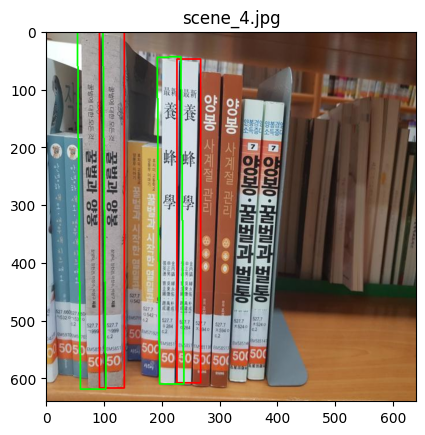

Results for scene: scene_5.jpg
------------------------------------
Book 13 - 1 instance(s) found:
  Instance 1 {top_left: (102, 69), top_right: (145, 69), bottom_right: (145, 572), bottom_left: (102, 572), area: 21629px}



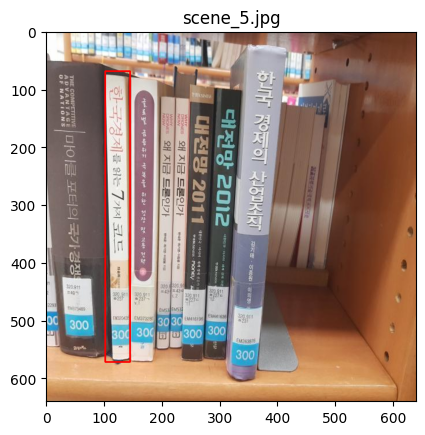

Results for scene: scene_6.jpg
------------------------------------
Book 21 - 1 instance(s) found:
  Instance 1 {top_left: (217, 73), top_right: (270, 73), bottom_right: (270, 563), bottom_left: (217, 563), area: 25970px}



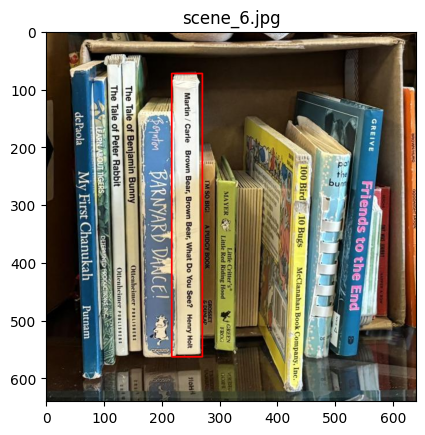

Results for scene: scene_7.jpg
------------------------------------
Book 20 - 2 instance(s) found:
  Instance 1 {top_left: (236, 173), top_right: (289, 173), bottom_right: (289, 555), bottom_left: (236, 555), area: 20246px}
  Instance 2 {top_left: (279, 170), top_right: (334, 171), bottom_right: (330, 563), bottom_left: (275, 562), area: 21564px}



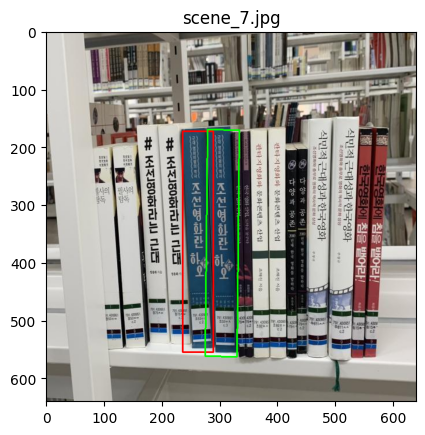

Results for scene: scene_8.jpg
------------------------------------
No books found.


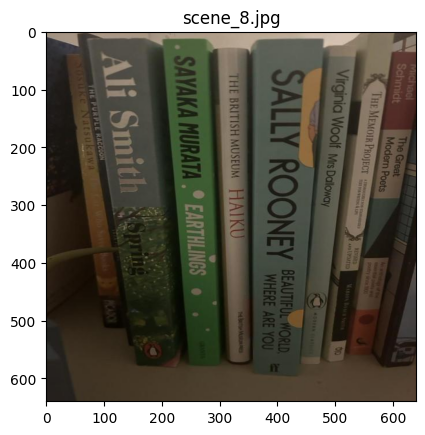

Results for scene: scene_9.jpg
------------------------------------
Book 19 - 4 instance(s) found:
  Instance 1 {top_left: (436, 329), top_right: (437, 356), bottom_right: (138, 366), bottom_left: (138, 339), area: 8064px}
  Instance 2 {top_left: (438, 356), top_right: (439, 383), bottom_right: (138, 394), bottom_left: (137, 367), area: 8138px}
  Instance 3 {top_left: (436, 299), top_right: (438, 326), bottom_right: (137, 342), bottom_left: (136, 315), area: 8138px}
  Instance 4 {top_left: (442, 380), top_right: (443, 407), bottom_right: (140, 421), bottom_left: (139, 394), area: 8195px}



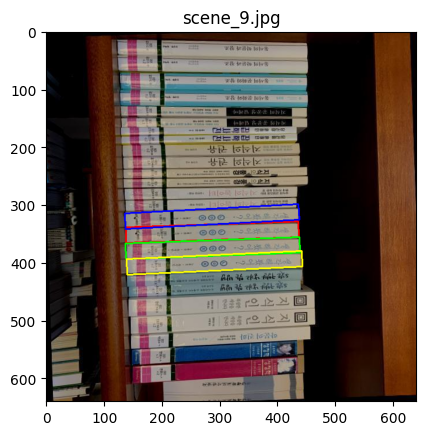

Results for scene: scene_10.jpg
------------------------------------
Book 19 - 4 instance(s) found:
  Instance 1 {top_left: (332, 203), top_right: (359, 203), bottom_right: (359, 503), bottom_left: (332, 503), area: 8100px}
  Instance 2 {top_left: (385, 200), top_right: (412, 200), bottom_right: (414, 503), bottom_left: (386, 503), area: 8332px}
  Instance 3 {top_left: (308, 202), top_right: (335, 202), bottom_right: (332, 505), bottom_left: (304, 505), area: 8332px}
  Instance 4 {top_left: (356, 202), top_right: (384, 201), bottom_right: (389, 505), bottom_left: (361, 505), area: 8500px}



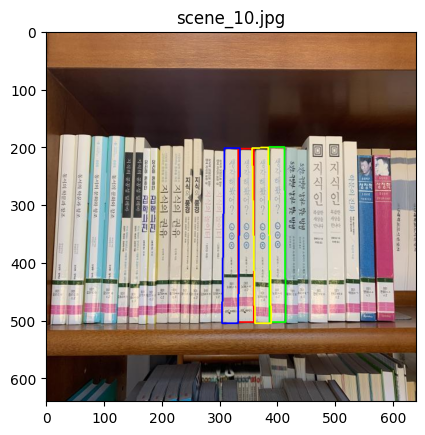

Results for scene: scene_11.jpg
------------------------------------
No books found.


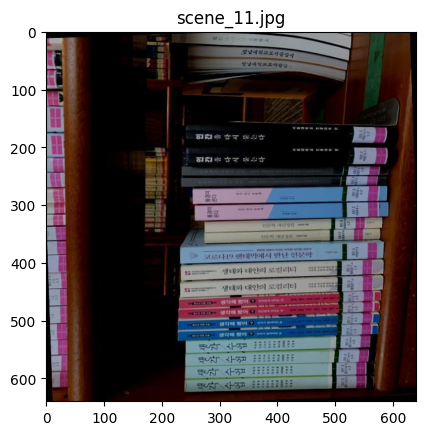

Results for scene: scene_12.jpg
------------------------------------
No books found.


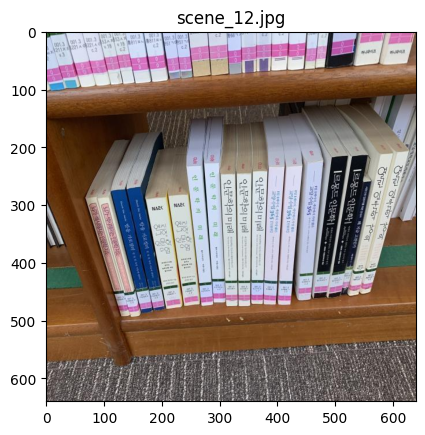

Results for scene: scene_13.jpg
------------------------------------
No books found.


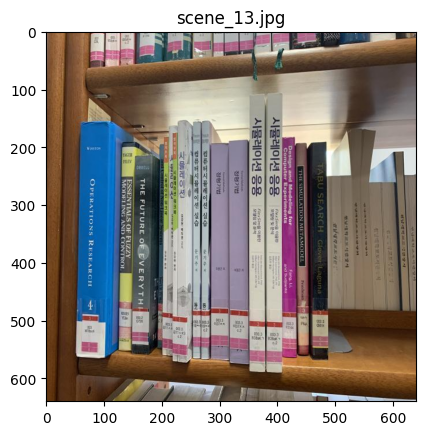

Results for scene: scene_14.jpg
------------------------------------
No books found.


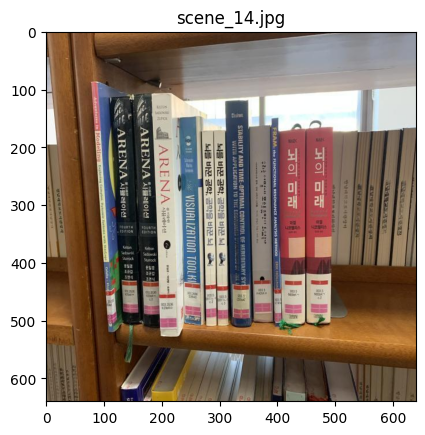

Results for scene: scene_15.jpg
------------------------------------
Book 11 - 1 instance(s) found:
  Instance 1 {top_left: (258, 187), top_right: (299, 187), bottom_right: (291, 535), bottom_left: (250, 534), area: 14252px}
Book 12 - 3 instance(s) found:
  Instance 1 {top_left: (500, 214), top_right: (529, 215), bottom_right: (523, 527), bottom_left: (494, 527), area: 9066px}
  Instance 2 {top_left: (473, 212), top_right: (503, 213), bottom_right: (499, 529), bottom_left: (470, 528), area: 9326px}
  Instance 3 {top_left: (525, 216), top_right: (553, 216), bottom_right: (548, 523), bottom_left: (520, 523), area: 8596px}



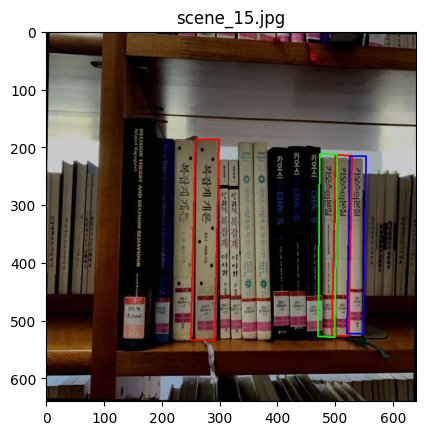

Results for scene: scene_16.jpg
------------------------------------
Book 11 - 1 instance(s) found:
  Instance 1 {top_left: (259, 186), top_right: (300, 188), bottom_right: (290, 535), bottom_left: (249, 534), area: 14262px}
Book 12 - 3 instance(s) found:
  Instance 1 {top_left: (500, 214), top_right: (529, 215), bottom_right: (523, 527), bottom_left: (494, 527), area: 9066px}
  Instance 2 {top_left: (474, 212), top_right: (503, 213), bottom_right: (497, 528), bottom_left: (468, 528), area: 9152px}
  Instance 3 {top_left: (525, 216), top_right: (553, 216), bottom_right: (548, 524), bottom_left: (520, 523), area: 8612px}



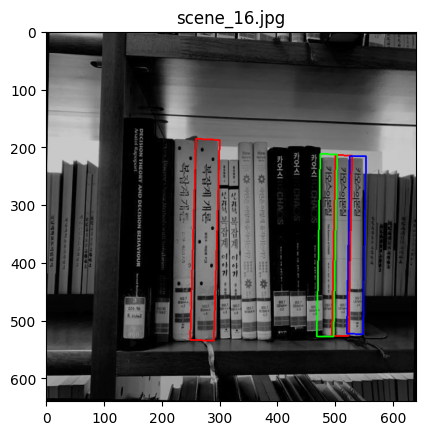

Results for scene: scene_17.jpg
------------------------------------
Book 11 - 1 instance(s) found:
  Instance 1 {top_left: (254, 187), top_right: (295, 187), bottom_right: (295, 535), bottom_left: (254, 535), area: 14268px}
Book 12 - 1 instance(s) found:
  Instance 1 {top_left: (497, 211), top_right: (526, 211), bottom_right: (526, 523), bottom_left: (497, 523), area: 9048px}



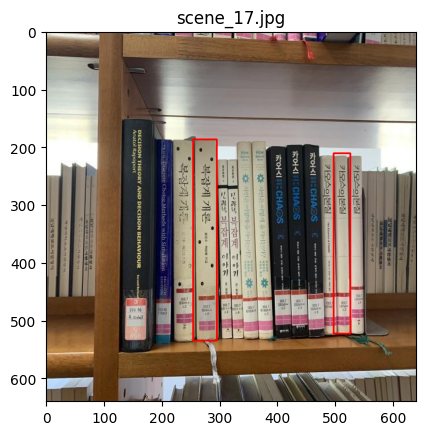

Results for scene: scene_18.jpg
------------------------------------
Book 8 - 3 instance(s) found:
  Instance 1 {top_left: (291, 131), top_right: (318, 131), bottom_right: (317, 586), bottom_left: (290, 586), area: 12285px}
  Instance 2 {top_left: (266, 128), top_right: (293, 128), bottom_right: (291, 585), bottom_left: (264, 585), area: 12339px}
  Instance 3 {top_left: (314, 133), top_right: (341, 133), bottom_right: (343, 587), bottom_left: (316, 587), area: 12258px}
Book 9 - 3 instance(s) found:
  Instance 1 {top_left: (315, 130), top_right: (342, 130), bottom_right: (342, 586), bottom_left: (315, 586), area: 12312px}
  Instance 2 {top_left: (267, 125), top_right: (294, 125), bottom_right: (289, 584), bottom_left: (262, 584), area: 12393px}
  Instance 3 {top_left: (291, 128), top_right: (319, 128), bottom_right: (316, 586), bottom_left: (289, 586), area: 12595px}
Book 10 - 3 instance(s) found:
  Instance 1 {top_left: (108, 38), top_right: (135, 38), bottom_right: (135, 584), bottom_

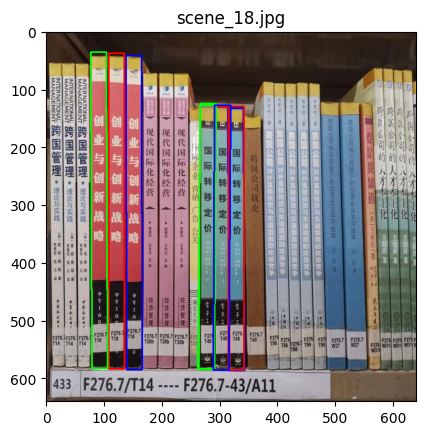

Results for scene: scene_19.jpg
------------------------------------
Book 6 - 3 instance(s) found:
  Instance 1 {top_left: (385, 31), top_right: (411, 31), bottom_right: (410, 579), bottom_left: (384, 579), area: 14248px}
  Instance 2 {top_left: (438, 25), top_right: (464, 25), bottom_right: (464, 578), bottom_left: (438, 578), area: 14378px}
  Instance 3 {top_left: (410, 29), top_right: (436, 29), bottom_right: (436, 577), bottom_left: (410, 577), area: 14248px}
Book 7 - 2 instance(s) found:
  Instance 1 {top_left: (497, 40), top_right: (533, 40), bottom_right: (533, 587), bottom_left: (497, 587), area: 19692px}
  Instance 2 {top_left: (457, 43), top_right: (493, 42), bottom_right: (497, 584), bottom_left: (461, 584), area: 19496px}



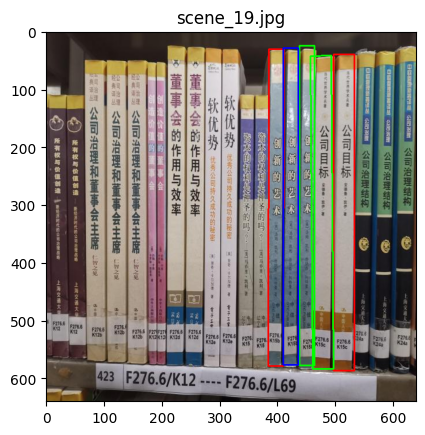

Results for scene: scene_20.jpg
------------------------------------
No books found.


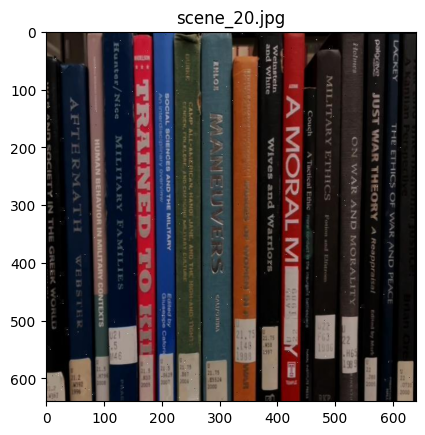

Results for scene: scene_21.jpg
------------------------------------
No books found.


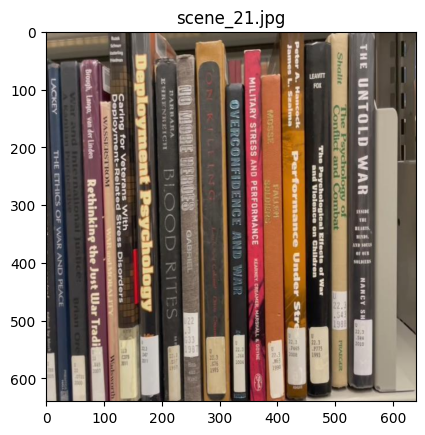

Results for scene: scene_22.jpg
------------------------------------
No books found.


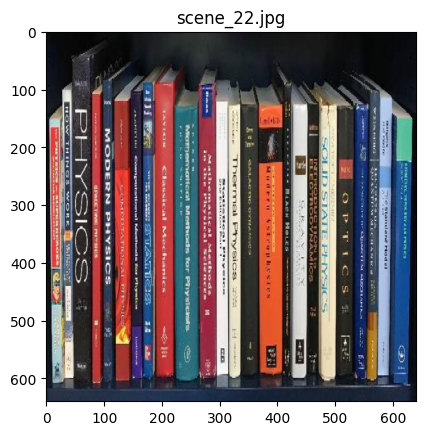

Results for scene: scene_23.jpg
------------------------------------
Book 5 - 1 instance(s) found:
  Instance 1 {top_left: (342, 149), top_right: (391, 149), bottom_right: (391, 571), bottom_left: (342, 571), area: 20678px}



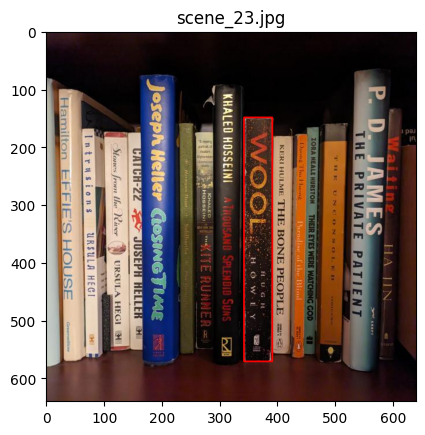

Results for scene: scene_24.jpg
------------------------------------
No books found.


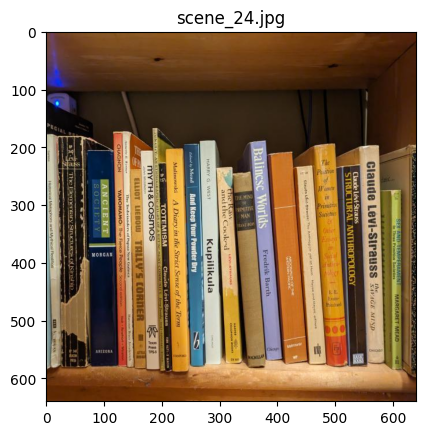

Results for scene: scene_25.jpg
------------------------------------
No books found.


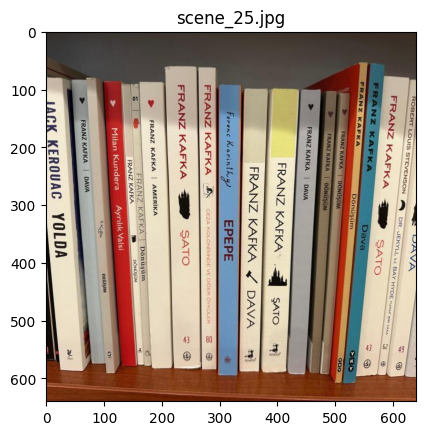

Results for scene: scene_26.jpg
------------------------------------
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (209, 180), top_right: (243, 180), bottom_right: (244, 567), bottom_left: (210, 567), area: 13158px}
  Instance 2 {top_left: (170, 181), top_right: (204, 181), bottom_right: (208, 571), bottom_left: (174, 571), area: 13260px}
Book 4 - 1 instance(s) found:
  Instance 1 {top_left: (248, 183), top_right: (432, 183), bottom_right: (432, 526), bottom_left: (248, 526), area: 63112px}



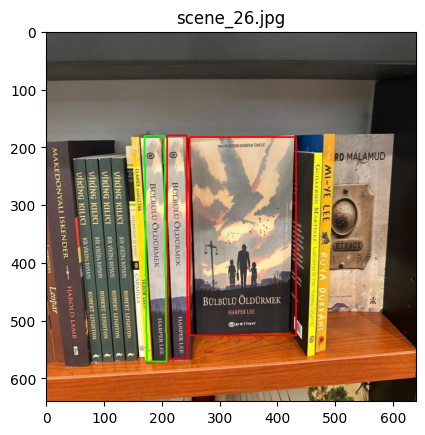

Results for scene: scene_27.jpg
------------------------------------
Book 2 - 2 instance(s) found:
  Instance 1 {top_left: (257, 146), top_right: (302, 146), bottom_right: (302, 563), bottom_left: (257, 563), area: 18765px}
  Instance 2 {top_left: (304, 102), top_right: (357, 102), bottom_right: (355, 601), bottom_left: (302, 600), area: 26422px}
Book 3 - 2 instance(s) found:
  Instance 1 {top_left: (421, 144), top_right: (457, 145), bottom_right: (444, 569), bottom_left: (408, 568), area: 15277px}
  Instance 2 {top_left: (369, 144), top_right: (406, 144), bottom_right: (399, 574), bottom_left: (363, 574), area: 15695px}



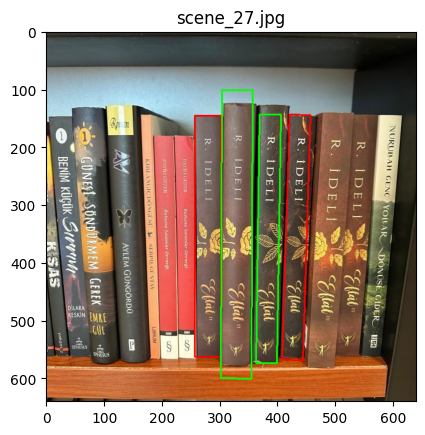

Results for scene: scene_28.jpg
------------------------------------
Book 1 - 2 instance(s) found:
  Instance 1 {top_left: (206, 248), top_right: (235, 248), bottom_right: (235, 554), bottom_left: (206, 554), area: 8874px}
  Instance 2 {top_left: (237, 245), top_right: (265, 245), bottom_right: (265, 550), bottom_left: (236, 550), area: 8692px}



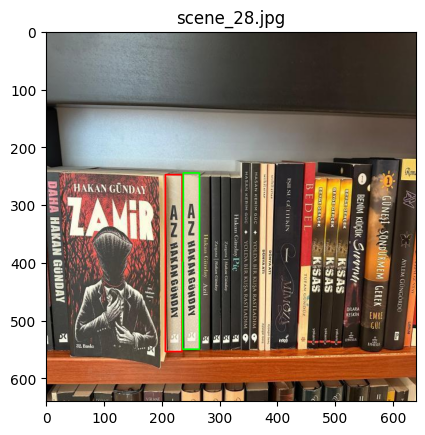

In [12]:
scene_files = sorted(os.listdir(SCENES_DIR), key=natural_sort_key)

for scene_filename in scene_files:
    if not scene_filename.lower().endswith((".png", ".jpg", ".jpeg")):
        continue

    scene_path = os.path.join(SCENES_DIR, scene_filename)
    scene_image = cv2.imread(scene_path)
    overlay_image = scene_image.copy()
    all_detections = {}

    for book_name, model_image in models.items():
        peaks, accumulator, bounding_boxes = detector.detect(model_image, scene_image)

        valid_boxes = [b for b in bounding_boxes if b.get("bounding_box") is not None]
        if valid_boxes:
            all_detections[book_name] = valid_boxes

            colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255)]

            for i, det in enumerate(valid_boxes):
                color = colors[i % len(colors)]
                corners = np.int32(det["bounding_box"])
                cv2.polylines(
                    overlay_image, [corners], isClosed=True, color=color, thickness=2
                )

    format_and_print_results(all_detections, scene_filename)

    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.title(scene_filename)
    plt.show()

## Conclusion

In conclusion, after careful parameter tuning, this system proved capable of detecting 91.1% of the object instances across all scenes (51 out of 56), demonstrating its robustness.

One limitation remains, due to model images that are slightly different from those present in the scene. An example is scenes `scene_15.jpg`, `scene_16.jpg` and `scene_17.jpg`, where one of the two instances of Book 11 is consistently missed, mainly because the book spine appears faded compared to the original.


Possible improvements could be explored, although this is always challenging when dealing with classical computer vision approaches. While reliable in industrial contexts, such approaches struggle to generalize to scenes that differ significantly from those for which the parameters were tuned.

## References

- Zuiderveld, K. (1994). Contrast Limited Adaptive Histogram Equalization. In *Graphics Gems IV* (pp. 474-485), Academic Press Professional.
- Lowe, D. G. (2004). Distinctive Image Features from Scale-Invariant Keypoints. *International Journal of Computer Vision*, 60(2), 91-110.
- Ballard, D. H. (1981). Generalizing the Hough Transform to detect arbitrary shapes. *Pattern Recognition*, 13(2), 111-122.
- Prof. Lisanti's lecture slides.